In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import keras
import numpy as np
from models import model_v2
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network

2024-03-01 00:02:13.649326: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 00:02:13.683341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 00:02:13.683375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 00:02:13.684256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 00:02:13.690573: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

batch_size=8
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train_Resize"
val_path = Path(root) / "Phase2" / "Data" / "Val_Resize"

rho=32
train_gen = DataGenerator(train_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)
val_gen = DataGenerator(val_path,
                          mode="unsupervised_with_h4pt",
                          rho=rho,
                          crop_size=128)


# tensorflow dataset
im_crop_shape = (train_gen.crop_size,train_gen.crop_size,3)
im_ori_shape = (train_gen.resize_shape[1],train_gen.resize_shape[0],3)

output_signature=(  #input
                    (tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=(2,),dtype=tf.float32),
                    ),
                     # output
                    (tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32), 
                     tf.TensorSpec(shape=(8,),dtype=tf.float32))
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen,
                                          output_signature=output_signature)

train_ds = config_ds(train_ds)
val_ds = config_ds(val_ds)

sample_input, sample_output = next(iter(train_ds))
print("input shapes:")
for i in sample_input:
    print(i.shape)
print("output shape")
for i in sample_output:
    print(i.shape)

2024-03-01 00:02:15.693012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 00:02:15.728264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 00:02:15.735440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

reshuffling dataset
input shapes:
(8, 128, 128, 3)
(8, 128, 128, 3)
(8, 240, 320, 3)
(8, 2)
output shape
(8, 240, 320, 3)
(8, 8)


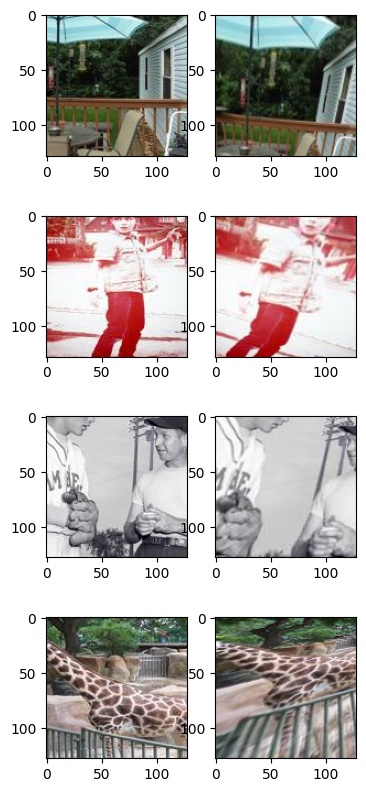

In [4]:
# plot some samples
import matplotlib.pyplot as plt
sample_input, sample_output = next(iter(train_ds))

plt.figure(figsize=(4,10))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
plt.show()

In [5]:
# a = tf.Variable(1.0)
# tf.debugging.check_numerics(a, message='')

# b = tf.Variable(np.nan)
# try:
#   tf.debugging.check_numerics(b, message='Checking b')
#   print("bbbb")
# except Exception as e:
#   assert "Checking b : Tensor had NaN values" in e.message
#   print(e.message)

# c = tf.Variable(np.inf)
# try:
#   tf.debugging.check_numerics(c, message='Checking c')
# except Exception as e:
#   assert "Checking c : Tensor had Inf values" in e.message

In [6]:
import sys
# define loss and metrics
def loss_img(y_true, y_pred):
    # y_true and y_pred are now batch of images
    return tf.reduce_mean(tf.abs(y_true-y_pred)) 
    # notice 1-norm is used


def metric_abs(y_true, y_pred):
    """computes the mean difference between predicted and actual corner shift
    values in x and y direction

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    return tf.reduce_mean(tf.abs(y_true-y_pred))

def metric_dist(y_true, y_pred):
    """compute the l2 distance between corner

    Args:
        y_true (_type_): _description_
        y_pred (_type_): _description_
    """
    d = tf.reshape(y_true,(-1,4,2))-tf.reshape(y_pred,(-1,4,2))
    return tf.reduce_mean(tf.norm(d,ord='euclidean',axis=-1))

# build new model with TensorDLT and STN added
homography_net = model_v2()
homography_net.load_weights('./chkpt_weight/checkpoint_mdl_v2_rho32')

# retrieve the input of the network
cropped_img1 = keras.layers.Input(shape=im_crop_shape)
cropped_img2 = keras.layers.Input(shape=im_crop_shape)
img_ori = keras.layers.Input(shape=im_ori_shape)

h4pt_batch = homography_net([cropped_img1,cropped_img2]) # batch by 8
h4pt_batch = tf.clip_by_value(h4pt_batch,clip_value_min=-rho,clip_value_max=rho)

upper_left_corner = keras.layers.Input(shape=(2,)) # batch by 2

# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=h4pt_batch,
                       upper_left_corner=upper_left_corner,
                       batch_size=batch_size)

# use spatial transformer to get predicted image
img_pred = spatial_transformer_network(img_ori,
                                       homography,
                                       img_height=im_ori_shape[0],
                                       img_width=im_ori_shape[1],
                                       )

class FullModel(keras.Model):
    def __init__(self, inputs, outputs):
        super().__init__(inputs=inputs, outputs=outputs)
        self.loss_tracker = keras.metrics.MeanAbsoluteError(name='mae_loss')
        self.metric_h4pt = keras.metrics.MeanAbsoluteError(name='mae_h4pt')
        self.loss_tracker_val = \
            keras.metrics.MeanAbsoluteError(name='val_mae_loss')
        self.metric_h4pt_val = \
            keras.metrics.MeanAbsoluteError(name='val_mae_h4pt')

    @tf.function
    def train_step(self, data):
        data_in, data_out = data
        with tf.GradientTape() as tape:
            model_out = self(data_in, training=True)
            loss = keras.losses.mean_absolute_error(y_true=data_out[0],
                                                    y_pred=model_out[0])

        grads = tape.gradient(loss, self.trainable_variables)

        # check if grad has nan, if so simply return
        try:
            for g in grads:
                tf.debugging.check_numerics(g, message='Checking grad')
            # do gradient update
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

            self.loss_tracker.update_state(data_out[0], model_out[0])
            self.metric_h4pt.update_state(data_out[-1], model_out[-1])

        except Exception as e:
            tf.print("==================== nan found ====================",)

        return {"mae_loss": self.loss_tracker.result(),
            "mae_h4pt": self.metric_h4pt.result()}
    
    def test_step(self, data):
        data_in, data_out = data
        model_out = self(data_in, training=False)

        self.loss_tracker_val.update_state(data_out[0], model_out[0])
        self.metric_h4pt_val.update_state(data_out[-1], model_out[-1])

        return {"val_mae_loss": self.loss_tracker_val.result(),
            "val_mae_h4pt": self.metric_h4pt_val.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.metric_h4pt]
    
full_model = FullModel(inputs=[cropped_img1,
                                 cropped_img2,
                                 img_ori,
                                 upper_left_corner,
                                 ], 
                        outputs=[img_pred,h4pt_batch])

# rename output layers
full_model.layers[2]._name = 'h4pt_output'
full_model.layers[-1]._name = 'img_output'
full_model.summary()

# compile model
full_model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-5))


new init


2024-03-01 00:02:18.633464: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-01 00:02:19.082311: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8bcaaf0


checking nan
Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 h4pt_output (Functional)    (None, 8)                    3777980   ['input_4[0][0]',             
                                                          0          'input_5[0][0]']             
                                                                                                  
 tf.clip_by_value (TFOpLamb  (None, 8)                    0         ['h4pt_o

2024-03-01 00:02:20.183695: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-01 00:02:20.262330: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[ -7.  22.  16.  25.  23. -12.   2.  22.]
 [-17.  -5.  -5. -32.  31. -21.   1.  32.]
 [ -8.  12.  23. -26.  22.  13.  10.  24.]
 [ 30.  32.  11. -30. -32.  30.  30.   7.]
 [ -9. -29. -16.  13.  19.   6. -31.   0.]
 [ 22. -11.  26.  22.  13.   5.  11.   0.]
 [  3.  -3. -27.  14. -18.  20. -17.  29.]
 [-19.  18.  25. -17. -23.  -2.  24.  21.]], shape=(8, 8), dtype=float32)
tf.Tensor(
[[ -9.  22.  17.  26.  23. -10.   0.  20.]
 [-20.  -5.  -4. -30.  29. -18.   4.  31.]
 [-14.  11.  23. -25.  22.  12.  13.  21.]
 [  7.  20.  21. -30. -30.  28.  25.   7.]
 [-15. -30. -12.  10.  23.   5. -31.   3.]
 [ 22. -11.  28.  19.  10.   6.  10.  -2.]
 [  3.  -2. -24.  13. -13.  18. -15.  25.]
 [-18.  19.  23. -19. -15.   3.  23.  19.]], shape=(8, 8), dtype=float32)


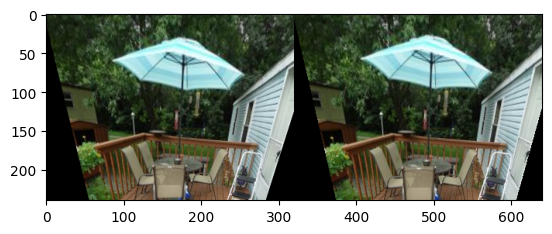

In [7]:
import numpy as np
# try calling the full model with sample input
sample_model_output = full_model(sample_input)
assert(sample_model_output[0].shape==sample_input[2].shape)
print(sample_output[-1])
print(tf.round(sample_model_output[1]))

import matplotlib.pyplot as plt
plt.imshow(np.hstack( ((sample_output[0][0,:,:,:]).numpy(),
                      (sample_model_output[0][0,:,:,:]).numpy())
            )
           )


In [8]:
import numpy as np
steps_per_epoch = int(np.floor(5000/batch_size))

# reduce learning rate when performance plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='mae_loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

# save check points
checkpoint_filepath = './chkpt_weight/checkpoint_mdl_unsupervised'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='mae_loss',
                                                mode='min',
                                                save_best_only=True
                                                )

# start training
history = full_model.fit(train_ds,
                         epochs=100,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_ds,
                         validation_steps=int(np.floor(1000/batch_size)),
                         validation_freq=1,
                         verbose=True,
                         callbacks=[reduce_lr, checkpoint_callback])

Epoch 1/100


2024-03-01 00:02:34.236159: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3ed78d02d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 00:02:34.236200: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-01 00:02:34.240816: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709269354.308380  206029 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - ETA: 0s - mae_loss: 0.1220 - mae_h4pt: 6.5065reshuffling dataset
reshuffling dataset
625/625 [==============================] - 85s 111ms/step - mae_loss: 0.1220 - mae_h4pt: 6.5065 - val_val_mae_loss: 0.0814 - val_val_mae_h4pt: 2.8866 - lr: 1.0000e-05
Epoch 2/100
 98/625 [===>..........................] - ETA: 48s - mae_loss: 0.1235 - mae_h4pt: 6.5435

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


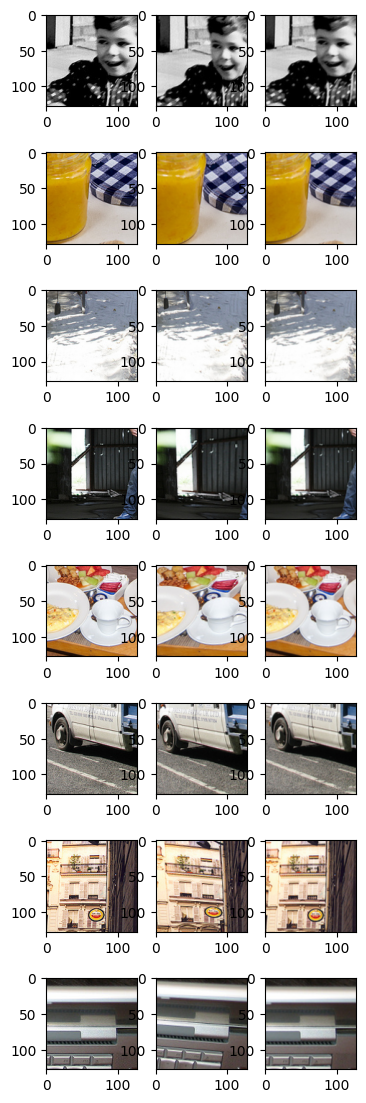

In [71]:
# see how the model is doing
sample_model_output = full_model(sample_input)
plt.figure(figsize=(4,14))
for i in range(8):
    plt.subplot(8,3,3*i+1)
    plt.imshow(tf.squeeze(sample_input[0][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+2)
    plt.imshow(tf.squeeze(sample_input[1][i,:,:,:])/255.)
    plt.subplot(8,3,3*i+3)
    plt.imshow(tf.squeeze(sample_model_output[i,:,:,:])/255.)
plt.show()